<a href="https://colab.research.google.com/github/Sunnn-y/NaturalLanguageProcessing/blob/main/20231020_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D_%EC%8B%A4%EC%8A%B5(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN 감정분석

## 실습 2
- 네이버 영화 리뷰데이터로 감정 분석 -> 어제 acc 너무 낮게 나와서 재도전..

In [1]:
# 구글 드라이브 마운트(연결)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/핀테크 데이터분석/자연어 처리/review.csv',
                 sep = '\t')
# df = df[:100]
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 토큰화 및 데이터 전처리

In [6]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 49.8 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Okt
tokenizer = Okt()

df['morphs'] = None
for i, row in df.iterrows():
  df['morphs'][i] = ' '.join(tokenizer.morphs(row['document']))

<ipython-input-6-eab88834c7d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['morphs'][i] = ' '.join(tokenizer.morphs(row['document']))


In [ ]:
df.head()

,id,document,label,morphs
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙 .. 진짜 짜증나네요 목소리
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍지 않구나
2,10265843,너무재밓었다그래서보는것을추천한다,0,너 무재 밓었 다그 래서 보는것을 추천 한 다
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기 구먼 .. 솔직히 재미 는 없다 .. 평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이 몬페 그 의 익살스런 연기 가 돋보였던 영화 ! 스파이더맨 에서 늙어 보이기만...


In [ ]:
import re
# 한글을 제외한 다른 문자 모두 제거
remove_except_ko = re.compile(r"[^가-힣ㄱ-하-ㅣ\\s]")

def preprocess_remove(text):
  text = re.sub(remove_except_ko,' ',text).strip()
  return text

df['morphs'] = df['morphs'].map(lambda x : preprocess_remove(x))
df.head()

In [ ]:
# 불용어 처리
stop_word = ['포스터', '저작권자', '한경', '닷컴', '뉴스룸', '홈페이지', '바로', '네이버', '구독', '채널', '세요', '제공','께서', '라고', '입니다', '습니다', '한다', '에서', '이다', '에게', '으로', '이랑', '까지', '부터', '하다', '한데', '통해', '위해', '때문' ]

def preprocess(text):
  text = text.split()
  text = [i for i in text if len(i)>1]
  text = [i for i in text if i not in stop_word]
  return text

In [ ]:
# 토큰화 + 토큰리스트 생성
def make_tokens(df):
  df['tokens'] = None
  for i, row in df.iterrows():
    if i%1000==0:
      print(i,'/',len(df))
    token = preprocess(df['morphs'][i])
    df['tokens'][i] = ' '.join(token)
  return df

df = make_tokens(df)

0 / 10000


<ipython-input-10-86dc58720036>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'][i] = ' '.join(token)


1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000


In [ ]:
df.head()

,id,document,label,morphs,tokens
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙 진짜 짜증나네요 목소리,더빙 진짜 짜증나네요 목소리
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍지 않구나,보고 초딩 영화 오버 연기 조차 가볍지 않구나
2,10265843,너무재밓었다그래서보는것을추천한다,0,너 무재 밓었 다그 래서 보는것을 추천 한 다,무재 밓었 다그 래서 보는것을 추천
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기 구먼 솔직히 재미 는 없다 평점 조정,교도소 이야기 구먼 솔직히 재미 없다 평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이 몬페 그 의 익살스런 연기 가 돋보였던 영화 스파이더맨 에서 늙어 보이기만...,사이 몬페 익살스런 연기 돋보였던 영화 스파이더맨 늙어 보이기만 했던 커스틴 던스트...


### 데이터 인코딩

In [ ]:
# 유니크한 토큰 개수 확인
token_list = []
for i in df['tokens']:
  token_list.extend(i.split(' '))
  # break

len(token_list)

83564

In [ ]:
x = df.iloc[:, -1]
y = df.iloc[:, 2]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
                                                    random_state = 2) # test_size 의 디폴트값은 0.25

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
print(tokenizer.word_index)

{'영화': 1, '정말': 2, '너무': 3, '진짜': 4, '연기': 5, '평점': 6, '최고': 7, '스토리': 8, '하고': 9, '이런': 10, '사람': 11, '드라마': 12, '보고': 13, '감동': 14, '하는': 15, '생각': 16, 'ㅋㅋ': 17, '감독': 18, '그냥': 19, '시간': 20, '내용': 21, '재미': 22, '배우': 23, '작품': 24, '보다': 25, '없는': 26, '하나': 27, '쓰레기': 28, '사랑': 29, '없다': 30, '이건': 31, '마지막': 32, '정도': 33, '같은': 34, '있는': 35, '이렇게': 36, '연출': 37, '봤는데': 38, '액션': 39, '주인공': 40, '다시': 41, '장면': 42, '좋은': 43, '느낌': 44, 'ㅋㅋㅋ': 45, '지금': 46, '없고': 47, '보는': 48, '역시': 49, '이야기': 50, '처음': 51, '최악': 52, '완전': 53, '명작': 54, 'ㅡㅡ': 55, '인데': 56, '별로': 57, 'ㅠㅠ': 58, '봐도': 59, '그리고': 60, '해서': 61, '같다': 62, '이나': 63, '많이': 64, '보면': 65, '이해': 66, '이영화': 67, '결말': 68, '재밌게': 69, '아깝다': 70, '인생': 71, '한번': 72, '가슴': 73, '소재': 74, '무슨': 75, '이고': 76, '라는': 77, '마음': 78, '여자': 79, '매력': 80, '남자': 81, '가장': 82, '기억': 83, '보기': 84, '모든': 85, '지만': 86, '없이': 87, 'ㅎㅎ': 88, '인가': 89, '하지만': 90, '수준': 91, '인간': 92, '전개': 93, '되는': 94, '현실': 95, '캐릭터': 96, '하지': 97, '실망': 98, '반전': 99, '전혀

In [ ]:
# 등장 빈도수 3회 미만인 토큰이 전체에서 얼마나 비중을 차지하는지 확인
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items(): # word_counts : 단어의 빈도수를 계산해주는 함수 # items() : kev값과 value값을 쌍으로 받음
  total_freq += value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if(value < threshold):
    rare_cnt += 1
    rare_freq += value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 17340
등장 빈도가 2번 이하인 희귀 단어의 수: 13455
단어 집합에서 희귀 단어의 비율: 77.59515570934255
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 23.594787750917494


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3886


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(x_train[:3])

[[5, 1317, 3, 62, 23, 607, 128, 101, 21, 3, 765, 172, 46, 148, 12, 62], [649, 128, 26, 96, 1318, 26, 8, 2210, 1527, 202, 221, 1319, 2804, 2805, 2806, 1320, 250, 1321, 265, 1322, 2211], [396, 1026, 2807, 173, 2808, 564, 1027, 35, 1]]


In [ ]:
import numpy as np
y_train = np.array(y_train)
y_test = np.array(y_test)

### 빈 샘플 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
x_train = np.delete(x_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(x_train))
print(len(y_train))

7668
7668


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### 패딩(padding)

리뷰의 최대 길이 : 33
리뷰의 평균 길이 : 6.706181533646323


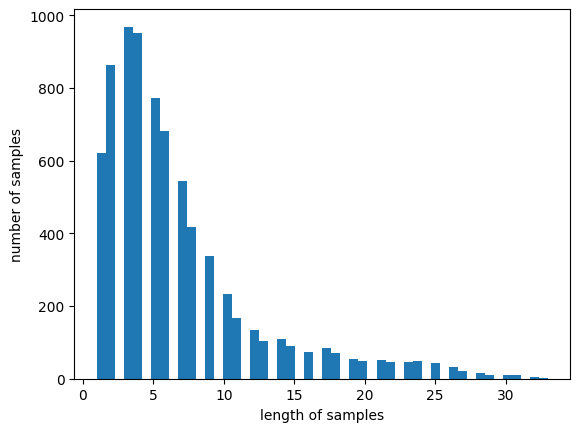

In [ ]:
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(review) for review in x_train))
print('리뷰의 평균 길이 :',sum(map(len, x_train))/len(x_train))
plt.hist([len(review) for review in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 오늘것도 그래프 왜이래..??

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.77829942618675


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

### 감정분석 모델링

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # 과적합 방지를 위해 조기 중단
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[mc], batch_size=64, validation_split=0.2)

Epoch 1/15
96/96 [==============================] - ETA: 0s - loss: 0.6783 - acc: 0.5856
Epoch 1: val_acc improved from -inf to 0.69361, saving model to best_model.h5
96/96 [==============================] - 14s 98ms/step - loss: 0.6783 - acc: 0.5856 - val_loss: 0.6153 - val_acc: 0.6936
Epoch 2/15
 2/96 [..............................] - ETA: 6s - loss: 0.5943 - acc: 0.6875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - ETA: 0s - loss: 0.5145 - acc: 0.7571
Epoch 2: val_acc improved from 0.69361 to 0.74967, saving model to best_model.h5
96/96 [==============================] - 12s 131ms/step - loss: 0.5145 - acc: 0.7571 - val_loss: 0.5009 - val_acc: 0.7497
Epoch 3/15
96/96 [==============================] - ETA: 0s - loss: 0.3790 - acc: 0.8357
Epoch 3: val_acc improved from 0.74967 to 0.77705, saving model to best_model.h5
96/96 [==============================] - 13s 138ms/step - loss: 0.3790 - acc: 0.8357 - val_loss: 0.4674 - val_acc: 0.7771
Epoch 4/15
96/96 [==============================] - ETA: 0s - loss: 0.3066 - acc: 0.8709
Epoch 4: val_acc improved from 0.77705 to 0.77771, saving model to best_model.h5
96/96 [==============================] - 8s 85ms/step - loss: 0.3066 - acc: 0.8709 - val_loss: 0.4723 - val_acc: 0.7777
Epoch 5/15
96/96 [==============================] - ETA: 0s - loss: 0.2649 - acc: 0.8906
Epoch 5: val_acc did not improve from 0.77771
96

### 정확도(acc), f1 score 구하기

In [ ]:
model.evaluate(x_test, y_test)

63/63 [==============================] - 2s 24ms/step - loss: 0.7686 - acc: 0.7415


[0.7686436176300049, 0.7415000200271606]

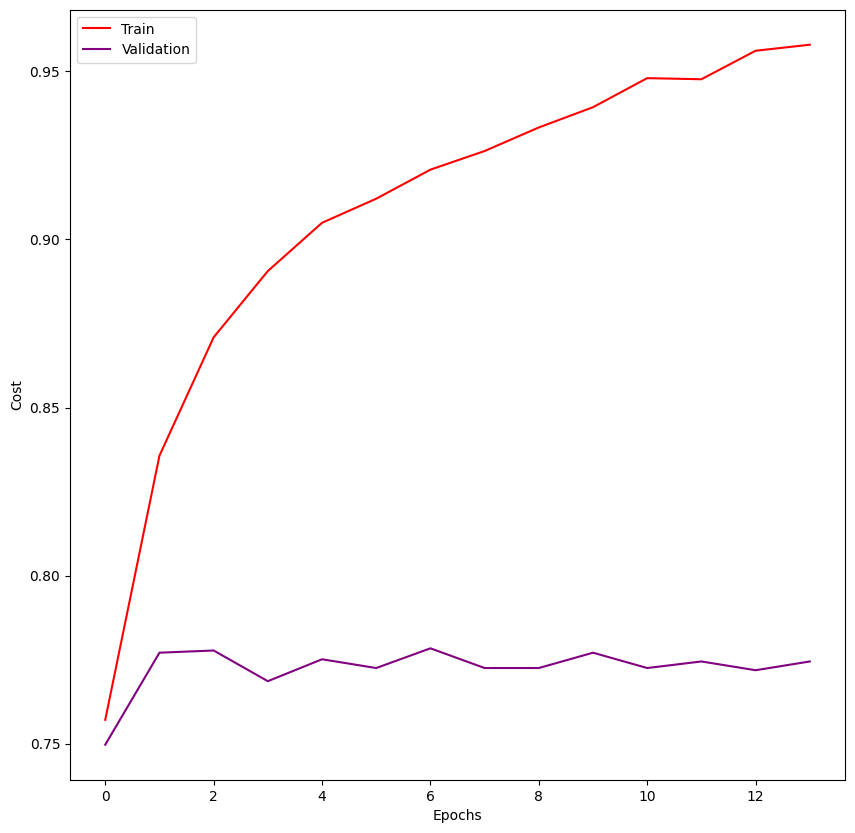

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'][1:], label='Train', color='red')
plt.plot(history.history['val_acc'][1:], label='Validation', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [ ]:
## 오늘 것도 그래프 왜이래 진짜....................
## 토큰화 할 때 사용한 패키지가 토큰 개수 1개짜리 document를 자동적으로 지워버린 것 같음. (그래서 패딩 전 그래프에서 빈값 나온 것으로 추측) 이거 해결해보기

## 실습 2 - 다른 풀이

### 데이터 전처리

In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/핀테크 데이터분석/자연어 처리/review.csv',
                 sep = '\t')
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
import re
# 한글을 제외한 다른 문자 모두 제거
remove_except_ko = re.compile(r"[^가-힣ㄱ-하-ㅣ\\s]")

def preprocess_remove(text):
  text = re.sub(remove_except_ko,' ',text).strip()
  return text

df['document'] = df['document'].map(lambda x : preprocess_remove(x))
df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
from konlpy.tag import Okt
tokenizer = Okt()

# 토큰화 / 불용어 처리
stop_pos =  ['Josa', 'Eomi', 'Punctuation', 'Foreign', 'Number', 'Unknown', 'KoreanParticle']
stop_word = ['영화']

df['morphs'] = None
for i, row in df.iterrows():
  tokens = tokenizer.pos(row['document'])
  token_ls = []
  for token in tokens:
    if len(token[0]) > 1:
      if token[0] not in stop_word:
        if token[1] not in stop_pos:
          token_ls.append(token[0])
  # print(token_ls)
  df['morphs'][i] = ' '.join(token_ls)

<ipython-input-7-8e266f87902b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['morphs'][i] = ' '.join(token_ls)


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['morphs'], df['label'], random_state = 0) # test_size 의 디폴트값은 0.25

tokenizer = Tokenizer() # 선언
tokenizer.fit_on_texts(x_train) # make train word set

In [9]:
print(len(tokenizer.word_index))
tokenizer.word_index

16111


{'정말': 1,
 '너무': 2,
 '진짜': 3,
 '연기': 4,
 '평점': 5,
 '최고': 6,
 '스토리': 7,
 '사람': 8,
 '보고': 9,
 '이런': 10,
 '드라마': 11,
 '하는': 12,
 '생각': 13,
 '감동': 14,
 '시간': 15,
 '그냥': 16,
 '감독': 17,
 '배우': 18,
 '내용': 19,
 '재미': 20,
 '쓰레기': 21,
 '없는': 22,
 '작품': 23,
 '사랑': 24,
 '하나': 25,
 '주인공': 26,
 '없다': 27,
 '이건': 28,
 '있는': 29,
 '같은': 30,
 '정도': 31,
 '다시': 32,
 '마지막': 33,
 '이렇게': 34,
 '봤는데': 35,
 '액션': 36,
 '완전': 37,
 '처음': 38,
 '연출': 39,
 '입니다': 40,
 '장면': 41,
 '최악': 42,
 '지금': 43,
 '느낌': 44,
 '역시': 45,
 '명작': 46,
 '없고': 47,
 '보는': 48,
 '이야기': 49,
 '봐도': 50,
 '그리고': 51,
 '별로': 52,
 '좋은': 53,
 '많이': 54,
 '보면': 55,
 '같다': 56,
 '이해': 57,
 '이영화': 58,
 '아깝다': 59,
 '기억': 60,
 '해서': 61,
 '인생': 62,
 '마음': 63,
 '남자': 64,
 '재밌게': 65,
 '한다': 66,
 '결말': 67,
 '때문': 68,
 '보기': 69,
 '한번': 70,
 '없이': 71,
 '무슨': 72,
 '가슴': 73,
 '매력': 74,
 '가장': 75,
 '여자': 76,
 '하지만': 77,
 '되는': 78,
 '현실': 79,
 '인간': 80,
 '하게': 81,
 '하고': 82,
 '수준': 83,
 '반전': 84,
 '솔직히': 85,
 '소재': 86,
 '공감': 87,
 '재밌다': 88,
 '모든': 89,
 '대한': 90,
 '코

In [10]:
x_train[:2]

2967                                      존경 하시는
700     음악 취향 저격 비긴 어게인 대중 흥행 하긴 힘들 하지만 여주 너무 매력
Name: morphs, dtype: object

In [11]:
# 단어를 숫자배열로 전환
x_train_array_list = tokenizer.texts_to_sequences(x_train)
x_test_array_list = tokenizer.texts_to_sequences(x_test)

# 레이블링 데이터 행렬변환
y_train = np.array(y_train) # 형 변환 : x와 타입을 동일하게 맞추기 위해서 진행
y_test = np.array(y_test)
print('훈련데이터 X: ', len(x_train_array_list))
print('훈련데이터 Y: ', len(y_train))

훈련데이터 X:  7500
훈련데이터 Y:  7500


In [12]:
# 확인
print(x_train[:2])
print(x_train_array_list[:2])

2967                                      존경 하시는
700     음악 취향 저격 비긴 어게인 대중 흥행 하긴 힘들 하지만 여주 너무 매력
Name: morphs, dtype: object
[[616, 1616], [118, 464, 5826, 3548, 3549, 1985, 295, 1986, 1987, 77, 351, 2, 74]]


리뷰의 최대 길이 : 149
리뷰의 평균 길이 : 26.0936


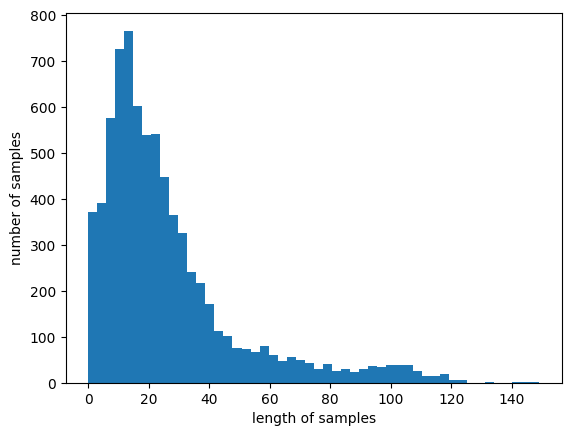

In [13]:
print('리뷰의 최대 길이 :',max(len(review) for review in x_train))
print('리뷰의 평균 길이 :',sum(map(len, x_train))/len(x_train))
plt.hist([len(review) for review in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
# 편하게 쓰기 위해 변수명 재할당
x_train = x_train_array_list
x_test = x_test_array_list

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 길이 35로 패딩
max_len = 35
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [16]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        616, 1616], dtype=int32)

### 모델링

In [17]:
# 구글 드라이브 경로 설정
path = '/content/'

In [18]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = len(x_train) # 학습데이터 길이 = vocab_size
embedding_dim = 100

model = Sequential() # 모델 선언
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

참고
- monitor : 학습 조기종료를 위해 관찰하는 항목(default: val_loss) -> 이걸 쓰면 알아서 검증데이터가 추출돼서 loss값이 측정된다
- patience : 개선이 안된다고 바로 종료시키지 않고, 개선을 위해 몇번의 에포크를 기다릴지 설정(default = 0)
- verbose : 언제 train을 멈추었는지에 대한 것을 화면에 출력할지 여부(1 = 출력)
- mode : 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 설정. monitor에서 설정한 항목이 val_loss 이면 값이 감소되지 않을 때 종료하여야 하므로 min을 설정하고, val_accuracy의 경우에는 max를 설정해야 함. (default = auto)
> *   auto : monitor에 설정된 이름에 따라 자동으로 지정
> *   min : 관찰값이 감소하는 것을 멈출 때, 학습을 종료
> *   max : 관찰값이 증가하는 것을 멈출 때, 학습을 종료

In [19]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합이 될 수 있기 때문에 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/핀테크 데이터분석/자연어 처리', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [49]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.13

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.11.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.11.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [20]:
# generate model
# loss = 'sparse_categorical_crossentropy' 분류모델 사용
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=16, validation_split=0.2)

Epoch 1/15
368/375 [============================>.] - ETA: 0s - loss: 0.6359 - acc: 0.6114
Epoch 1: val_acc improved from -inf to 0.71800, saving model to /content/drive/MyDrive/핀테크 데이터분석/자연어 처리
375/375 [==============================] - 39s 72ms/step - loss: 0.6357 - acc: 0.6117 - val_loss: 0.5265 - val_acc: 0.7180
Epoch 2/15
369/375 [============================>.] - ETA: 0s - loss: 0.4412 - acc: 0.7893
Epoch 2: val_acc improved from 0.71800 to 0.76333, saving model to /content/drive/MyDrive/핀테크 데이터분석/자연어 처리
375/375 [==============================] - 10s 26ms/step - loss: 0.4423 - acc: 0.7883 - val_loss: 0.4779 - val_acc: 0.7633
Epoch 3/15
370/375 [============================>.] - ETA: 0s - loss: 0.3455 - acc: 0.8480
Epoch 3: val_acc did not improve from 0.76333
375/375 [==============================] - 4s 9ms/step - loss: 0.3451 - acc: 0.8482 - val_loss: 0.5212 - val_acc: 0.7473
Epoch 4/15
369/375 [============================>.] - ETA: 0s - loss:

In [21]:
print("\n 테스트 정확도: %.4f"% (model.evaluate(x_test, y_test)[1]))

79/79 [==============================] - 0s 4ms/step - loss: 0.6554 - acc: 0.7608

 테스트 정확도: 0.7608


In [22]:
y_predict = model.predict(x_test)
y_predict

79/79 [==============================] - 1s 2ms/step


array([[9.7612232e-01],
       [9.9937373e-01],
       [9.9938953e-01],
       ...,
       [5.4933262e-01],
       [9.9679001e-04],
       [9.8723197e-01]], dtype=float32)

In [23]:
y_predict2 = []
for x in y_predict:
  if x >= 0.5: # 출력층이 sigmoid니까 0.5 이상이 긍정
    y_predict2.append(1)
  else:
    y_predict2.append(0)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict2, target_names=['부정(0)', '긍정(1)']))

              precision    recall  f1-score   support

       부정(0)       0.79      0.71      0.75      1248
       긍정(1)       0.74      0.81      0.77      1252

    accuracy                           0.76      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.76      0.76      0.76      2500

